# Plot

In [53]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sys
import random
sys.path.append('../')
from auxPlots import getInfo, getDistributions, getATLASdistributions

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [ ]:
files = [
    '../../gg2ttbar-loop_scan/Events/run_05/events.lhe.gz',
    '../../gg2ttbar-loop_scan/Events/run_08/events.lhe.gz',
    # '../../qq2ttbar-loop_scan/Events/run_01/events.lhe.gz',
    # '../../qq2ttbar-loop_scan/Events/run_12/events.lhe.gz'
    ]
smFiles = list(glob.glob('../../pp2ttbar-loop_scan//Events/run_01/events.lhe.gz'))
bsmFiles = files[:]

xsecs = {
         '../../gg2ttbar-loop_scan/Events/run_05/events.lhe.gz' : -1.994,
         '../../gg2ttbar-loop_scan/Events/run_08/events.lhe.gz' : -1.994,
        #  '../../qq2ttbar-loop_scan/Events/run_01/events.lhe.gz' : 0.302,
        #  '../../qq2ttbar-loop_scan/Events/run_12/events.lhe.gz' : 0.302,
         '../../pp2ttbar-loop_scan//Events/run_01/events.lhe.gz' : 522.5
         }

In [55]:
# Get info
fileData = {f : getInfo(f) for f in bsmFiles}
for f in fileData:
    fileData[f]['model'] = 'BSM'
fileData.update({f : getInfo(f) for f in smFiles})
# Set SM model by hand:

allModels = sorted(list(set([info['model'] for info in fileData.values()])))
allPars = sorted(list(set([info['(mST,mChi,mT,yDM)'] for info in fileData.values()])))
allProcesses = sorted(list(set([info['process'] for info in fileData.values()])))
print(allModels)
print(allPars)
print(allProcesses)

['BSM', 'SM']
[(500.0, 400.0, 172.0, 5.0)]
['$p p \\to \\bar{t} t$']


In [56]:
# # Select files:
# models = ['SM','1-loop', 'EFT']
# pars = [(500.,400.,172.5,1.0)]
# procs = allProcesses[:]

# bsmFiles = files[:]
# smFiles = []
# for f,fInfo in fileData.items():
#     if fInfo['model'] not in models:
#         continue
#     if fInfo['process'] not in procs:
#         continue
        
#     if fInfo['model'] == 'SM':
#         smFiles.append(f)
#     else:
#         if fInfo['(mST,mChi,mT,yDM)'] not in pars:
#             continue
#         bsmFiles.append(f)
    
# print(bsmFiles)
# print(smFiles)
# Sort files so largest cross-sections come first
bsmFiles = sorted(bsmFiles, key = lambda f: (fileData[f]['process'],fileData[f]['model']), reverse=True)
smFiles = sorted(smFiles, key = lambda f: fileData[f]['process'], reverse=True)
selectedFiles = smFiles+bsmFiles

In [57]:
print(len(selectedFiles))
for f in selectedFiles:
    print(f)

3
../../pp2ttbar-loop_scan//Events/run_01/events.lhe.gz
../../gg2ttbar-loop_scan/Events/run_05/events.lhe.gz
../../gg2ttbar-loop_scan/Events/run_07/events.lhe.gz


### Get distributions without cuts

In [58]:

dists = {f : getDistributions(f) for f in selectedFiles}
# Randomly choose one of the momenta to use as the hadronic top pT
for f in dists:
    dists[f]['pTh'] = []
    for i,pt1 in enumerate(dists[f]['pT1']):
        pt2 =dists[f]['pT2'][i]
        dists[f]['pTh'].append(random.choice([pt1,pt2]))

In [59]:
for f,res in dists.items():    
    print('\n %s : %s' %(fileData[f]['model'],fileData[f]['process']))
    print('total xsec    = ',sum(res['weights'])*res['nevents'])
    print('MC events     = ',res['nevents'])


 SM : $p p \to \bar{t} t$
total xsec    =  519.1704130535505
MC events     =  85835

 BSM : $p p \to \bar{t} t$
total xsec    =  -1.9879941478228014
MC events     =  102787

 BSM : $p p \to \bar{t} t$
total xsec    =  -1.9937096683563662
MC events     =  51334


In [60]:
# Define colors
colors = {f : sns.color_palette('Paired')[i+1] for i,f in enumerate(dists.keys())}

### Plot invariant mass

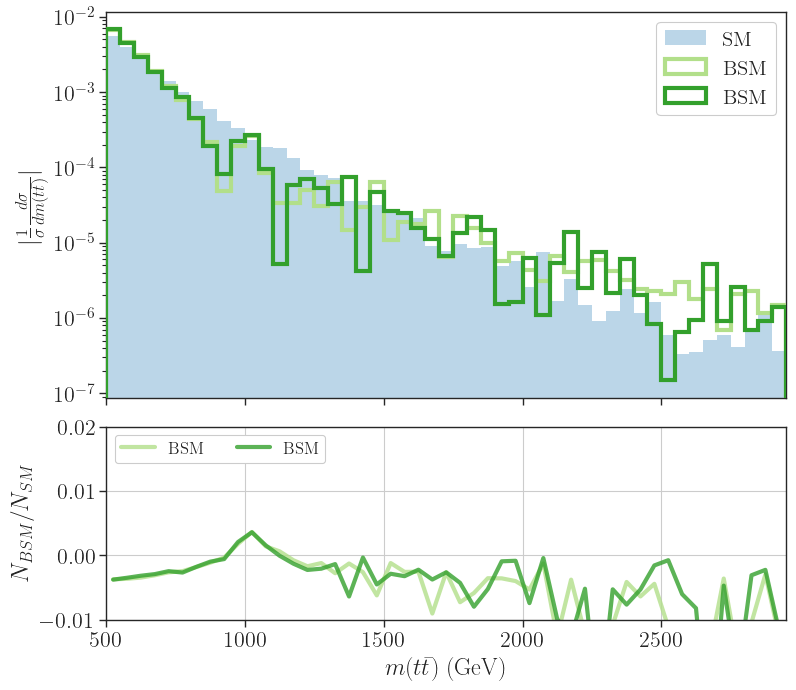

In [61]:
# Define scale factor (new yDM value)
# kscales = {f : 2.0 for f in smFiles} # The factor of 2 is to account for the 2 possible ttbar decays: (t -> jj, tbar->l nu) + (t -> l nu, tbar->jj)
# yDM = 5.0
# kscales.update({f : 2.0*(yDM/fileData[f]['(mST,mChi,mT,yDM)'][-1])**2 for f in bsmFiles})
kscales = {f : xsecs[f]/sum(res['weights']) for f,res in dists.items()}
yDM = fileData[bsmFiles[0]]['(mST,mChi,mT,yDM)'][-1] 

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
bins = np.arange(500.,3000.,50.)

labels = []
pmodels = []
hists = {}
histsErr = {}
c = []
ks = []
for f in dists:
    kscale = float(kscales[f])
    h,_ = np.histogram(dists[f]['mTT'],bins=bins,weights=(kscale*dists[f]['weights']))
    hists[f] = h
    #Compute MC error
    hErr,_ = np.histogram(dists[f]['mTT'],bins=bins,weights=(kscale*dists[f]['weights'])**2)
    histsErr[f] = np.sqrt(hErr)    


histsSM = [h for f,h in hists.items() if fileData[f]['model'] == 'SM']    
histsErrSM = [h for f,h in histsErr.items() if fileData[f]['model'] == 'SM']
# labelsSM = [l for i,l in enumerate(labels) if 'SM' in labels[i]]    
cSM =  [colors[f] for f in hists.keys() if fileData[f]['model'] == 'SM']    
axarr[0].hist([bins[:-1]]*len(histsSM),label='SM',bins=bins,
                          weights=histsSM,alpha=0.3,density=True,
                          linewidth=0,color=cSM,stacked=True)

hSM = sum(histsSM)
# hErrSM = np.sqrt(sum([hh**2 for hh in histsErrSM[:]]))
# labelsTrack = []
for f,h in hists.items():
    if fileData[f]['model'] == 'SM':
        continue
    hdiff = h
    axarr[0].hist(bins[:-1],weights=np.abs(hdiff),label=fileData[f]['model'],bins=bins,
                  color=colors[f],alpha=1.0,histtype='step',density=True,
                  linewidth=3,fill=False,zorder=i,linestyle='solid')
    
    # Compute ratio (keeping negative and positive values)
    ratio = np.divide(hdiff, hSM, out=np.zeros_like(hdiff),where=hSM != 0)
    # Remove zero values
    nonzero = np.where((np.sign(ratio) != 0))
    x = (bins[:-1]+bins[1:])/2.0
    y = ratio
    axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=0.8,
                          label=fileData[f]['model'],c=colors[f])

# Ratio plot:
# hLoop = sum([h for i,h in enumerate(hists) if '1-loop' in labels[i]])
# labels.append(r'$p p \to \bar{t} t$ (1-loop)')
# labels.append(r'$p p \to \bar{t} t$ (EFT)')
# c.append('black')
# c.append('gray')
# for i,h in enumerate(hists+[hLoop,hEFT]):
#     if 'SM' in labels[i]:
#         continue
#     if (not 'loop' in labels[i]) and (not 'p p ' in labels[i]):
#         continue
#     # Compute ratio (keeping negative and positive values)
#     ratio = np.divide(h, hSM, out=np.zeros_like(h),where=hSM != 0)
#     # Remove zero values
#     nonzero = np.where((np.sign(ratio) != 0))
#     x = (bins[:-1]+bins[1:])/2.0
#     y = ratio
#     label = labels[i]
#     axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=0.8,
#                           label=label,c=c[i])
        
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-4,500)
# axarr[0].set_xticks(np.arange(0.,bins.max(),500))
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[1].set_ylabel(r'$N_{BSM}/N_{SM}$')
axarr[1].set_ylim(-0.01,0.02)
axarr[1].set_yticks(np.arange(-0.01,0.03,0.01))
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].grid()


axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
# axarr[1].legend(framealpha=1.0,loc='upper left')
# axarr[0].set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mST,mChi,yDM),
                #    loc='left')
# plt.savefig('mtt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()